In [1]:
%autosave 0
import os
import glob
import numpy 
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np 
import tensorflow as tf
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import scatter_matrix 
from numpy import set_printoptions
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRFRegressor, XGBRegressor
from sklearn.compose import ColumnTransformer
from datetime import datetime
from mlflow import log_metric, log_param

set_printoptions(precision=0)
pd.set_option("display.precision", 2)
pd.option_context('display.float_format', '{:0f}'.format);

seed = 15
tf.random.set_seed(seed)
# tf.set_random_seed(seed)
numpy.random.seed(seed)

Autosave disabled


# création du dataset final

récupération de tous les fichiers csv commençant par dataset_final 

In [2]:
extension = 'csv'
all_filenames = [i for i in glob.glob('../csv/dataset_final_*.{}'.format(extension))]

concaténation de tous les fichiers récupérés afin d'en obtenir qu'un seul

In [3]:
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "../csv/dataset_final.csv", index=False, encoding='utf-8-sig')

# préprocessing du dataset

récupération du fichier csv concaténé précédement

In [4]:
# Importation du fichier csv dans un dataframe
df_train_full = read_csv('../csv/dataset_final.csv', index_col=0)
df_train_full.head()

,publish_date,city,departement,region,titre,type,living_area_m2,lot_size_m2,nb_room,nb_bedroom,pool,cellar,garage,output
ref,,,,,,,,,,,,,,
/fr/properties/11267a-yj21-1300.htm,2020-03-23,bordes,pyrénées-atlantiques,aquitaine,Maison,maison,160.0,2000.0,7.0,5.0,True,False,True,298900
/fr/properties/11267a-yj21-1319.htm,2020-03-23,baudreix,pyrénées-atlantiques,aquitaine,Maison,maison,220.0,2110.0,9.0,5.0,False,False,True,199300
/fr/properties/11267a-yj21-1303.htm,2020-03-23,nay,pyrénées-atlantiques,aquitaine,Arthez D'asson,autre,132.0,1714.0,6.0,3.0,False,False,True,143700
/fr/properties/11267a-yj21-1325.htm,2020-03-23,nay,pyrénées-atlantiques,aquitaine,Entrepôt,autre,168.0,1520.0,NaN,NaN,False,False,False,74990
/fr/properties/11267a-yj21-1234.htm,2020-03-23,bordes,pyrénées-atlantiques,aquitaine,Maison,maison,102.0,413.0,5.0,3.0,False,False,True,130000


mise en forme du dataframe

In [5]:
# df_train_full = df_train_full.set_index('ref')
df_train_full = df_train_full.drop(columns=['titre','publish_date'])
print(df_train_full.shape)
df_train_full.head(5)

(4800, 12)


,city,departement,region,type,living_area_m2,lot_size_m2,nb_room,nb_bedroom,pool,cellar,garage,output
ref,,,,,,,,,,,,
/fr/properties/11267a-yj21-1300.htm,bordes,pyrénées-atlantiques,aquitaine,maison,160.0,2000.0,7.0,5.0,True,False,True,298900
/fr/properties/11267a-yj21-1319.htm,baudreix,pyrénées-atlantiques,aquitaine,maison,220.0,2110.0,9.0,5.0,False,False,True,199300
/fr/properties/11267a-yj21-1303.htm,nay,pyrénées-atlantiques,aquitaine,autre,132.0,1714.0,6.0,3.0,False,False,True,143700
/fr/properties/11267a-yj21-1325.htm,nay,pyrénées-atlantiques,aquitaine,autre,168.0,1520.0,NaN,NaN,False,False,False,74990
/fr/properties/11267a-yj21-1234.htm,bordes,pyrénées-atlantiques,aquitaine,maison,102.0,413.0,5.0,3.0,False,False,True,130000


In [6]:
df_train_full.describe()

,living_area_m2,lot_size_m2,nb_room,nb_bedroom,output
count,4552.00,3.78e+03,4039.00,4024.00,4.80e+03
mean,276.42,1.61e+04,6.69,4.27,4.38e+05
std,870.06,7.00e+04,3.49,2.15,6.31e+05
min,1.00,1.00e+00,2.00,2.00,1.30e+04
25%,111.00,9.77e+02,4.00,3.00,1.74e+05
50%,165.00,2.32e+03,6.00,4.00,2.90e+05
75%,250.00,6.50e+03,8.00,5.00,4.80e+05
max,20000.00,1.52e+06,35.00,30.00,1.60e+07


split du dataframe en input et output

In [7]:
Y_trainfull = df_train_full['output']
X_trainfull = df_train_full.drop('output', axis=1)

In [8]:
print(Y_trainfull.shape)
print(X_trainfull.shape)

(4800,)
(4800, 11)


Récupération de la liste des villes

In [9]:
list_ville = X_trainfull["city"].unique()
list_departement = X_trainfull["departement"].unique()
list_region = X_trainfull["region"].unique()

In [10]:
df_ville = pd.DataFrame(list_ville, columns = ['list_ville'])
df_departement = pd.DataFrame(list_departement, columns = ['list_departement'])
df_region = pd.DataFrame(list_region, columns = ['list_region'])

frames = [df_ville, df_departement, df_region]

result = pd.concat(frames, axis=1)
result.to_csv('./templates/list_html.csv', index=False)

# Traitement des variables catégorielles

Sélection de toutes les colonnes concernant les variables catégorielles

In [11]:
cat_columns = ['city', 'departement', 'region', 'type']

création des pipelines onehotencoder afin de transformer les variables catégorielles en quantitatives

In [12]:
city_pipe = Pipeline(steps=[
    ('one', OneHotEncoder(categories = [X_trainfull['city'].unique()]))
])

In [13]:
departement_pipe = Pipeline(steps=[
    ('one', OneHotEncoder(categories = [X_trainfull['departement'].unique()]))
])

In [14]:
region_pipe = Pipeline(steps=[
    ('one', OneHotEncoder(categories = [X_trainfull['region'].unique()]))
])

In [15]:
type_pipe = Pipeline(steps=[
    ('one', OneHotEncoder(categories = [X_trainfull['type'].unique()]))
])

# Traitement des valeurs manquantes

Détection de la présence de valeurs manquantes

In [16]:
df_train_full.isna().any()

city              False
departement       False
region            False
type              False
living_area_m2     True
lot_size_m2        True
nb_room            True
nb_bedroom         True
pool              False
cellar            False
garage            False
output            False
dtype: bool

Sélection des colonnes de valeurs quantitatives

In [17]:
boolean_columns = ['pool', 'cellar', 'garage']
area_column = ['living_area_m2']
ground_column = ['lot_size_m2']
nb_room_column = ['nb_room']
nb_bedroom_column = ['nb_bedroom']

Création des pipelines gérant les valeurs manquantes dans les colonnes de valeurs quantitatives

In [18]:
area_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [19]:
ground_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

In [20]:
room_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1))
])

In [21]:
bedroom_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1))
])

# Construction du pipeline de pré-traitement

In [22]:
preprocess_pipe = ColumnTransformer(transformers=[
    ('city', city_pipe, ['city']),
    ('departement', departement_pipe, ['departement']),
    ('region', region_pipe, ['region']),
    ('type', type_pipe, ['type']),
    ('area', area_pipe, area_column),
    ('ground', ground_pipe, ground_column),
    ('room', room_pipe, nb_room_column),
    ('bedroom', bedroom_pipe, nb_bedroom_column),
])

# Choix du modèle et intégration dans la pipeline

Création de la fonction calculant la valeur moyenne absolut en pourcentage d'erreur

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

Création de la fonction de test de différents modèles

In [24]:
def mae_model(preprocess_pipe, model):

    full_pipe = Pipeline(steps=[
        ('pp', preprocess_pipe),
        ('model', model)
    ])

    X_train, X_val, Y_train, Y_val = train_test_split(X_trainfull, Y_trainfull,
                                                      test_size = 0.2, random_state = seed)

    full_pipe.fit(X_train, Y_train);

    y_train_pred = full_pipe.predict(X_train)
    y_val_pred = full_pipe.predict(X_val)

    mae_train = round(mean_absolute_percentage_error(Y_train, y_train_pred), 0)
    mae_val = round(mean_absolute_percentage_error(Y_val, y_val_pred), 0)

    return mae_train, mae_val

Liste des différents modèles

In [25]:
lin = LinearRegression()
#log = LogisticRegression()
tree = DecisionTreeRegressor()
rf = RandomForestRegressor()
bag = BaggingRegressor()
xgb = XGBRegressor()
xgb_rf = XGBRFRegressor()

In [26]:
models = [lin, tree, rf, bag, xgb, xgb_rf]

calcul du MAPE

In [27]:
errors = []
for model in models:
    errors += [mae_model(preprocess_pipe, model)]

print(errors)

[(55.0, 74.0), (0.0, 53.0), (16.0, 42.0), (17.0, 45.0), (39.0, 53.0), (89.0, 99.0)]


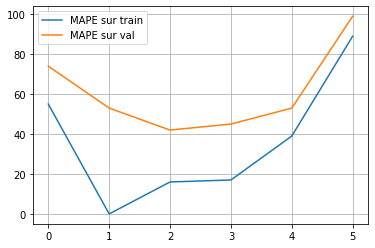

In [28]:
plt.plot(errors);
plt.grid();
plt.legend(['MAPE sur train', 'MAPE sur val']);

Du graphique précédent, nous choisissons de conserver le modèle 5 à savoir le modèle xgbregressor

# Génération du modèle retenu

In [29]:
model = XGBRegressor()

In [30]:
full_pipe = Pipeline(steps=[
        ('pp', preprocess_pipe),
        ('model', model)
    ])

In [31]:
full_pipe.fit(X_trainfull, Y_trainfull);

## exportation du modèle

In [32]:
# suppression du fichier si un ancien modèle existe
if os.path.exists('../models/full_pipe.file'):
    os.remove('../models/full_pipe.file')
else:
    print("Impossible de supprimer le fichier car il n'existe pas")

Impossible de supprimer le fichier car il n'existe pas


In [33]:
model_file_name = "../models/full_pipe_" + str(datetime.today())+ ".file"
last_model_name = "../models/full_pipe.file"

In [34]:
pickle.dump(full_pipe, open(model_file_name, "wb" ))
pickle.dump(full_pipe, open(last_model_name, "wb" ))

# Prédictions

## chargement du modèle

In [35]:
full_pipe = pickle.load(open(last_model_name, "rb"))

In [36]:
type(full_pipe)

sklearn.pipeline.Pipeline

## prédiction sur trainfull complet

In [37]:
X_trainfull

,city,departement,region,type,living_area_m2,lot_size_m2,nb_room,nb_bedroom,pool,cellar,garage
ref,,,,,,,,,,,
/fr/properties/11267a-yj21-1300.htm,bordes,pyrénées-atlantiques,aquitaine,maison,160.0,2000.0,7.0,5.0,True,False,True
/fr/properties/11267a-yj21-1319.htm,baudreix,pyrénées-atlantiques,aquitaine,maison,220.0,2110.0,9.0,5.0,False,False,True
/fr/properties/11267a-yj21-1303.htm,nay,pyrénées-atlantiques,aquitaine,autre,132.0,1714.0,6.0,3.0,False,False,True
/fr/properties/11267a-yj21-1325.htm,nay,pyrénées-atlantiques,aquitaine,autre,168.0,1520.0,NaN,NaN,False,False,False
/fr/properties/11267a-yj21-1234.htm,bordes,pyrénées-atlantiques,aquitaine,maison,102.0,413.0,5.0,3.0,False,False,True
/fr/properties/11267a-yj21-1133.htm,nay,pyrénées-atlantiques,aquitaine,autre,63.0,350.0,3.0,2.0,False,False,True
/fr/properties/5725a-301021.htm,cénac-et-saint-julien,dordogne,aquitaine,maison,85.0,NaN,5.0,3.0,False,False,False
/fr/properties/5725a-200968.htm,monpazier,dordogne,aquitaine,maison,190.0,1200.0,6.0,4.0,False,False,False
/fr/properties/14760a-136.htm,ribérac,dordogne,aquitaine,autre,95.0,475.0,6.0,4.0,False,False,True


In [38]:
y_train_pred = full_pipe.predict(X_trainfull)

In [39]:
mape_train = round(mean_absolute_percentage_error(Y_trainfull, y_train_pred), 0)
print('MAPE sur train : ', mape_train, '%')

MAPE sur train :  40.0 %


In [40]:
trainfull_pred = pd.DataFrame(y_train_pred)
trainfull_pred.to_csv('../csv/trainfull_pred.csv', index=False)
Y_trainfull.to_csv('../csv/Y_trainfull.csv', index=False)

## prédiction sur valeur unique

In [41]:
new_value = pd.DataFrame(data = [
    ['bordeaux', 'gironde', 'aquitaine', 'appartement', 54, 12, 1, 1, 'True', 'True', 'True']
    ], index = ['test'], columns = X_trainfull.columns)

new_value.index.name = 'ref'
new_value

,city,departement,region,type,living_area_m2,lot_size_m2,nb_room,nb_bedroom,pool,cellar,garage
ref,,,,,,,,,,,
test,bordeaux,gironde,aquitaine,appartement,54,12,1,1,True,True,True


In [42]:
full_pipe.predict(new_value)

array([222706.], dtype=float32)

# Enregistrement des résultats si voulus (mettre log = True)
-> accessible sous localhost:3000

In [43]:
log_param("X_trainfull.shape", X_trainfull.shape)
log_metric("MAPE sur train", mape_train)

/opt/conda/lib/python3.7/site-packages/py4j/java_collections.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import (
